# EDA DPF Failure

We want to find out what factors lead to failure.

`idle_duration_mins`: the total duration (minutes) the vehicle was idling for the day

`dpf_regen_inhibited_duration_mins`: the total duration (minutes) where dpf regen was inhibited for the day (regen cannot occur even if it needs to)

`dpf_regen_not_active_duration_mins`: the total duration (minutes) where dpf regen was not active for the day (regen not taking place)

`dpf_regen_needed_duration_mins`: the total duration (minutes) where dpf regen was reported as being needed for the day (regen needed but is not taking place)

`dpf_regen_inhibit_switch_active_duration_mins`: the total duration (minutes) where the driver accessible dpf inhibit switch was active for the day (regen inhibited by the driver)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from pandas.io.json import json_normalize
import seaborn as sns
import plotly.express as px
# Something to ensure that I can access the vnomics package
import sys
sys.path.insert(1, '../')

import vnomics
import plotly.offline as pyo
import plotly.graph_objs as go
import numpy as np

In [42]:
# To keep this consistent across different files
path = '../data_2021/'

In [43]:
# Creating an ETL object from the class I made in my Vnomics package
etl = vnomics.etl()

In [44]:
# Loading in all the data

# Ingesting the data
daily = etl.read_daily()
# Getting Daniel's Data - plus some modifying
data = etl.read_dan()

# Line Graphs



In [45]:
# Line 
features = ['percent_idle','percent_fuel_lost',
            'percent_regen_inhibited',
           'percent_regen_needed', 
            'percent_regen_inhibit_switch_not_active']

In [100]:
def inspect(pid = 301117, day_window = 50):
    ''' Inspects the time series trend of the key feature characterstics day_window days before the failure... 
    Paramaters
    ----------
    pid
    day_window
    
    Displays a figure inline.
    '''
    # Rightmost ID of the failure
    max_id = int(max(data[(data['platform_id']==pid) & (data['Failure'] == 1)].index))
    desired_window = [*range(max_id-day_window,max_id)]
    mask = [True if i in desired_window else False for i in data[data['platform_id']==pid].index]
    window = data[data['platform_id']==pid][mask]
    x_values = [*range(- window.shape[0], 0)]

    d = [go.Scatter(x=x_values, y=window[feature]*100, 
        mode = 'lines+markers', name = feature) for feature in features]
    layout=go.Layout(title="Key Feature Characteristics Before A Failure", xaxis = dict(tickangle = 90,
                                      showticklabels = True,
                                      type = "category",
                                      dtick = 1), hovermode = 'closest')
    fig = go.Figure(data=d, layout = layout)

    fig.update_layout(xaxis_title="Days From DPF Failure",
        yaxis_title="Percentage")
    fig.show()

In [113]:
# Aggregated data
agg_data = data.groupby("platform_id").sum()

# IMPORTANT: This finds all the PIDs with at least one failure in them
failure_pids = agg_data[agg_data['Failure']==15].index.tolist()

# Finding the non failure PIDs as the difference of the two sets
nonfailure_pids = list(set(data['platform_id'].tolist()) - set(failure_pids))

# All PIDs with a Failure
agg_data[agg_data['Failure']==15]

dpf_regen_not_active_duration_mins  \
platform_id                                       
300490                             52795.565967   
301117                            116268.492450   
301475                            119963.599167   
301585                            216466.630583   
301589                            180990.041683   
...                                         ...   
10317538                            7422.700350   
10318391                           20031.172467   
10318423                           22909.551550   
10321243                            6678.812733   
10321244                            8513.217133   

             dpf_regen_inhibited_duration_mins  \
platform_id                                      
300490                            68593.784250   
301117                           112676.369533   
301475                           140610.669067   
301585                           213247.745550   
301589                           167537.062650   
...                                        ...   
10317538                            911.969917   
10318391                            703.946483   
10318423                            323.767183   
10321243                            442.182083   
10321244                            515.385717   

             dpf_regen_needed_duration_mins  distance_miles  duration_mins  \
platform_id                                                                  
300490                             0.083300    64922.211905  118669.165883   
301117                           268.755683    81254.110667  136857.425233   
301475                             0.066650    93666.421351  182023.107583   
301585                          1398.933550   193994.989119  265926.834117   
301589                           124.209650   214542.279727  307483.787617   
...                                     ...             ...            ...   
10317538                         317.067000   335828.552234  413710.106800   
10318391                        1013.713267   302514.599755  433576.031783   
10318423                           0.000000   417608.493371  478106.974600   
10321243                        6558.774267   255128.809969  428134.642333   
10321244                        2740.924183   197383.756979  345059.661183   

             dpf_regen_active_duration_mins  Days of Rest  Failure  \
platform_id                                                          
300490                         24835.488150          95.0       15   
301117                          6524.362417         286.0       15   
301475                         37221.283333         293.0       15   
301585                         17577.756367         231.0       15   
301589                          1985.789867         151.0       15   
...                                     ...           ...      ...   
10317538                        3316.973683         142.0       15   
10318391                        4384.368833         148.0       15   
10318423                         372.018133         141.0       15   
10321243                       15347.384800         147.0       15   
10321244                        8364.337250         170.0       15   

             vehicle_serviced  fuel_used_gallons  fuel_loss_gallons  \
platform_id                                                           
300490                      1        9769.954558         270.567451   
301117                      1       12802.508807         775.526456   
301475                      1       14687.664523         486.707360   
301585                      1       28009.522445         825.630585   
301589                      1       30482.865557        1557.765304   
...                       ...                ...                ...   
10317538                    1       46888.234279        1314.155500   
10318391                    1       52381.832942        2735.692035   
10318423                    1       58965.052584         670.1

In [116]:
# Visualizing the platform distribution
all_pids = data['platform_id'].values.tolist()


In [109]:

for pid in failure_pids:
    inspect(pid)

In [66]:

# Taking just windows of 15 days before failure
window = data[(data['platform_id']==309450) & (data['Failure'] == 1)]

x_values = [*range(- window.shape[0], 0)]

d = [go.Scatter(x=x_values, y=window[feature]*100, 
    mode = 'lines+markers', name = feature) for feature in features]
layout=go.Layout(title="Key Feature Characteristics Before A Failure", xaxis = dict(tickangle = 90,
                                  showticklabels = True,
                                  type = "category",
                                  dtick = 1))
fig = go.Figure(data=d, layout = layout)

fig.update_layout(xaxis_title="Days From DPF Failure",
    yaxis_title="Percentage")
fig.show()

In [70]:
# Means
data.groupby("platform_id").sum()

dpf_regen_not_active_duration_mins  \
platform_id                                       
300490                             52795.565967   
300498                             96969.858633   
300500                            190573.704733   
300547                             83429.380067   
300558                            157773.572100   
...                                         ...   
10321243                            6678.812733   
10321244                            8513.217133   
10325986                           59482.257467   
10326022                           48800.171867   
10326079                            4048.425717   

             dpf_regen_inhibited_duration_mins  \
platform_id                                      
300490                            68593.784250   
300498                           130989.934800   
300500                           170367.183433   
300547                           111500.618517   
300558                           178694.743817   
...                                        ...   
10321243                            442.182083   
10321244                            515.385717   
10325986                          51582.150917   
10326022                          37768.769100   
10326079                           2666.307117   

             dpf_regen_needed_duration_mins  distance_miles  duration_mins  \
platform_id                                                                  
300490                             0.083300    64922.211905  118669.165883   
300498                             0.016683    72036.677140  210527.153133   
300500                           171.687067   153831.353036  242681.586117   
300547                             0.066717    66456.899680  222993.562700   
300558                         19911.609933    46831.911267  257093.675733   
...                                     ...             ...            ...   
10321243                        6558.774267   255128.809969  428134.642333   
10321244                        2740.924183   197383.756979  345059.661183   
10325986                          73.831700    52060.436103   61031.917417   
10326022                          41.680083    34765.475441   51067.205383   
10326079                          28.641517     1859.696106    4925.186617   

             dpf_regen_active_duration_mins  Days of Rest  Failure  \
platform_id                                                          
300490                         24835.488150          95.0       15   
300498                         48728.542100         199.0        0   
300500                          3189.995317         190.0        0   
300547                         51337.332867         164.0        0   
300558                         34942.665800         226.0        0   
...                                     ...           ...      ...   
10321243                       15347.384800         147.0       15   
10321244                        8364.337250         170.0       15   
10325986                         579.533983          18.0        0   
10326022                         468.292533          17.0        0   
10326079                         176.673417          30.0        0   

             vehicle_serviced  fuel_used_gallons  fuel_loss_gallons  \
platform_id                                                           
300490                      1        9769.954558         270.567451   
300498                      0       12173.779759         440.087782   
300500                      0       23135.475040        1942.188000   
300547                      0       10080.268953         756.511727   
300558                      0        7337.470222        1052.227469   
...                       ...                ...                ...   
10321243                    1       39206.367826        1735.176093   
10321244                    1       29067.694985        1188.670825   
10325986                    0        6916.199822          49.8

In [68]:
data

platform_id                          diagnostics_trouble_codes  \
0            309450                                                 []   
1            309450                                                 []   
2            309450  [{'j1939': {'severity': 'unclassified', 'fmi':...   
3            309450                                                 []   
4            309450                                                 []   
...             ...                                                ...   
111697     10325986  [{'j1939': {'severity': 'unclassified', 'fmi':...   
111698     10325986  [{'j1939': {'severity': 'unclassified', 'fmi':...   
111699     10325986  [{'j1939': {'severity': 'unclassified', 'fmi':...   
111700     10325986  [{'j1939': {'severity': 'unclassified', 'fmi':...   
111701     10325986  [{'j1939': {'severity': 'unclassified', 'fmi':...   

        dpf_regen_not_active_duration_mins  dpf_regen_inhibited_duration_mins  \
0                               154.504550                         145.853650   
1                               345.015933                         293.039250   
2                                41.469600                         115.026133   
3                                 0.000000                         111.522417   
4                                 0.000000                           0.000000   
...                                    ...                                ...   
111697                          786.525417                         753.899317   
111698                         1117.560300                        1003.531917   
111699                         1119.136317                        1008.166433   
111700                          791.055050                         686.138833   
111701                          123.104367                         100.253500   

        dpf_regen_needed_duration_mins  distance_miles  duration_mins  \
0                              0.00000       65.294602     222.002017   
1                              0.00000      210.269609     519.221017   
2                             46.78665       98.413486     354.276533   
3                              2.96690       74.838556     131.153333   
4                              0.00000        0.000000       0.000000   
...                                ...             ...            ...   
111697                        14.93560      776.873155     841.246750   
111698                         0.00000     1035.033122    1138.760183   
111699                         0.00000     1035.683687    1134.956167   
111700                         0.00000      694.809906     798.424467   
111701                         0.00000       95.052341     132.229917   

        dpf_regen_active_duration_mins  Days of Rest  Failure  ...  \
0                             0.000000           0.0        1  ...   
1                             0.000000           0.0        1  ...   
2                            57.857333           0.0        1  ...   
3                           123.756800           0.0        0  ...   
4                             0.000000           0.0        0  ...   
...                                ...           ...      ...  ...   
111697                       35.528000           0.0        0  ...   
111698                        0.000000           0.0        0  ...   
111699                        0.000000           0.0        0  ...   
111700                        0.000000           0.0        0  ...   
111701                        0.000000           0.0        0  ...   

       fuel_loss_gallons  dpf_regen_inhibit_switch_not_active_duration_mins  \
0               0.057875                                                0.0   
1               0.495596                                                0.0   
2               0.281884                                                0.0   
3               0.225600                                                0.0   
4               0.000000         

In [13]:
# Seeing Line for Each Feature = Failure vs Non Failure
x = data[features[0]]


## Platform IDs

In [10]:
pid_group = data.groupby('platform_id').size()
pid_group

platform_id
300490      441
300498      729
300500      715
300547      729
300558      729
           ... 
10321243    729
10321244    727
10325986     96
10326022     92
10326079     48
Length: 161, dtype: int64

Here we see that one platform ID may have different numbers of trucks.

Here, we see that the minimum number of trucks in any given platform is 48 - but honestly most trucks safely have 729.

However, it is nice to see that most platforms have 729 trucks exactly.

In [17]:
counts = pid_group.value_counts().index.sort_values().tolist()
counts

[48,
 92,
 96,
 268,
 285,
 302,
 309,
 352,
 394,
 400,
 441,
 560,
 570,
 665,
 679,
 710,
 713,
 715,
 716,
 717,
 718,
 722,
 723,
 725,
 727,
 728,
 729,
 730]

In [18]:
sum(pid_group.value_counts().values)

161

We have a total of 161 platforms in the dataset.

We want to make sure we have enough data before the failure happens - so no failure within the first 15 days.

We may have to aggregate the dates to make it less granular.
We may need some windowing - take 15 rows at a time to feed it in TSFresh.
For each batch of 15 rows, we are trying to make a prediction

For each of the 69 trucks that don't have DPF failure, how much time series data do you want to feed? This is where we want to do that windowing.

### Wrangling

To have a standard number of time series windows - I drop the platform IDs that do not have the top number of vehicles in them. I just create this as a separate data.

In [19]:
def standardize_window(raw_data):
    '''Takes out the data that has less than 729 time window in the data
    
    '''
    pid_group = all_data.groupby('platform_id').size()
    
    # Here I take the platform IDs that has 729
    full_pids = [index for index, value in 
                 zip(pid_group.index, pid_group.values) if value == 729]

    # Just looking at the head of this
    full_pids[:5]
    
    # Just a unit test to prove that we are taking a subset of all the PIDs
    print(f"Before: {len(full_pids)} rows \nAfter: {len(pid_group)} rows")
    
    # Subsetting the data to only the platforms with a time series window of 729
    mask = [i in full_pids for i in all_data['platform_id']]
    fullwindow_data = all_data[mask]
    
    return fullwindow_data

In [20]:
fullwindow_data = standardize_window(all_data)
fullwindow_data.head()

Before: 112 rows 
After: 161 rows


date  platform_id  distance_miles  fuel_used_gallons  duration_mins  \
0 2019-01-02       309450       65.294602           7.743177     222.002017   
1 2019-01-03       309450      210.269609          32.266755     519.221017   
2 2019-01-04       309450       98.413486          15.543700     354.276533   
3 2019-01-05       309450       74.838556          13.602637     131.153333   
4 2019-01-06       309450        0.000000           0.000000       0.000000   

   idle_duration_mins  fuel_loss_gallons  dpf_regen_inhibited_duration_mins  \
0           44.141633           0.057875                         145.853650   
1          134.957617           0.495596                         293.039250   
2           83.660883           0.281884                         115.026133   
3           30.391967           0.225600                         111.522417   
4            0.000000           0.000000                           0.000000   

   dpf_regen_not_inhibited_duration_mins  dpf_regen_not_active_duration_mins  \
0                               8.650900                          154.504550   
1                              51.976683                          345.015933   
2                              31.087450                           41.469600   
3                              15.201283                            0.000000   
4                               0.000000                            0.000000   

   dpf_regen_active_duration_mins  dpf_regen_needed_duration_mins  \
0                        0.000000                         0.00000   
1                        0.000000                         0.00000   
2                       57.857333                        46.78665   
3                      123.756800                         2.96690   
4                        0.000000                         0.00000   

   dpf_regen_inhibit_switch_not_active_duration_mins  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   dpf_regen_inhibit_switch_active_duration_mins  vehicle_serviced  \
0                                            0.0                 0   
1                                            0.0                 0   
2                                            0.0                 1   
3                                            0.0                 0   
4                                            0.0                 0   

                           diagnostics_trouble_codes  
0                                                 []  
1                                                 []  
2  [{'j1939': {'severity': 'unclassified', 'fmi':...  
3                                                 []  
4                                                 []

In [21]:
# Saving
fullwindow_data.to_csv(path + 'fullwindow_data.csv')

In [22]:
# To show the difference between this and the initial data
all_data.shape

(111702, 16)

# Correlation

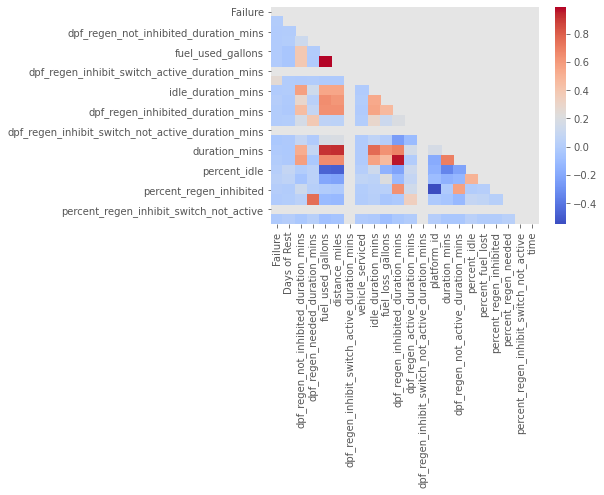

In [53]:
corr = data.corr()
matrix = np.triu(corr)
sns.heatmap(corr, cmap = "coolwarm", mask=matrix);

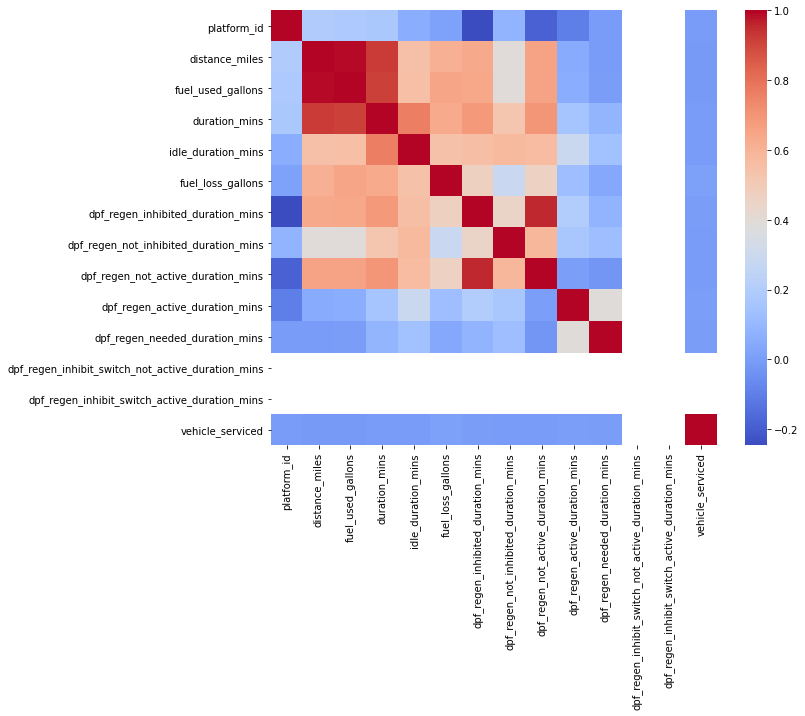

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(all_data.corr(), cmap = 'coolwarm');

# Train Test Split

We have to make sure to do this EARLIER rather than later in the data pipeline.